In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [231]:
# append all 508 files into one big table - each row is one county, one year 
directory = 'data_cleaned'

# get 508 files
first = True
for filename in os.listdir(directory):
    if first==True and filename.endswith("508_data.csv"): 
        joined = pd.read_csv(os.path.join(directory, filename))
        first = False
    elif filename.endswith("508_data.csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        joined = joined.append(df)
        
joined.reset_index(inplace=True)
joined.shape

(31019, 26)

In [232]:
# randomly split into train and validate
train=joined.sample(frac=0.75,random_state=201,replace=False)
validate = joined.drop(train.index)

In [233]:
# write to file
train.to_csv("data_cleaned/training_all_counties_all_years.csv")
validate.to_csv("data_cleaned/validate_all_counties_all_years.csv")

In [239]:
# join tables horizontally across all years
# to see which counties are available over time

directory = 'data_cleaned'

# get 508 files
first = True
for filename in os.listdir(directory):
    if first==True and filename.endswith("508_data.csv"): 
        joined = pd.read_csv(os.path.join(directory, filename))
        joined.set_index('Unnamed: 0', inplace=True)
        print(joined.shape)
        first = False
    elif filename.endswith("508_data.csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        df.set_index('Unnamed: 0', inplace=True)
        joined = pd.concat([df, joined], axis=1)
        
joined.shape

(567, 24)


(1473, 840)

1473 unique counties

Only 361 counties are avaialble across all years.

In [241]:
joined.dropna(thresh=34).shape

(1434, 840)

In [242]:
nrows = 24
count=[]
for i in range(35):
    count.append(joined.dropna(thresh=i*nrows).shape[0])

In [243]:
df = pd.DataFrame()
df["Number of Counties"] = count
df["Number of Years"] = range(35)

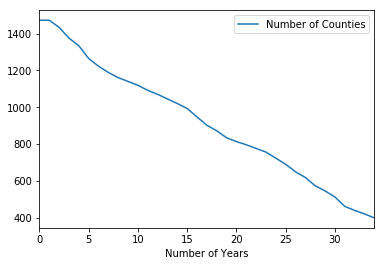

In [244]:
df.plot(y="Number of Counties", x="Number of Years")

Use nearby counties to impute missing values. Distance source:
    http://www.nber.org/data/county-distance-database.html
        
Gives a lookup table with the distance to counties within 25 miles for every FIPS county

In [245]:
dist = pd.read_csv("data/sf12010countydistance25miles.csv", encoding='mbcs')
all_counties = joined['FIPS']
dist_counties = dist["county1"]
lookup_counties =np.intersect1d(dist_counties, all_counties).astype(dtype='int64')
dist.set_index('county1', inplace=True)
dist = dist.loc[lookup_counties]

In [189]:
def impute_values(df, dist):
    filled = pd.DataFrame(columns = df.columns.values)
    for i in dist.index:
#         check if missing air quality data
#         print(df.loc[i]['Median AQI'])
        if(i not in df.index):
            print("inside")
#         get any nearby counties
            n = np.array(dist.loc[i]["county2"])
            for nbr in n:
                if(nbr in df.index):
                    f=df.loc[n]
                    f['FIPS'] = i   
                    filled.append(f)
    return filled

In [190]:
directory = 'data_cleaned'

# get 508 files
for filename in os.listdir(directory):
    if filename.endswith("508_data.csv"): 
        df = pd.read_csv(os.path.join(directory, filename))
        df.set_index('FIPS', inplace=True)
        filled = impute_values(df, dist)
        print("done")
    break

inside


TypeError: iteration over a 0-d array